In [33]:
####################################################
#Se describe el sistema a resolver, condiciones de frontera, condiciones iniciales, solución exacta
#Se resuelve la ecuación de calor u_t - nu*u'' = f, en una dimensión, con elementos finitos fenics para la parte espacial
# y forward euler para la parte temporal, con condiciones de frontera Dirichlet Homogeneas,
# con la condicion inicial, u(0,t)=0, la solucion exacta del sistema es la función u=4x(1-x)

####################################################
'''
revisa la condici'on inicial y la soluci'on exacta, as'i como est'an escritas no tienen 
mucho sentido para el problema
'''
#Libraries

from fenics import *
import fenics as fn
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from copy import copy, deepcopy
import sys
from time import time

In [34]:
####################################################
#FEM Params 

'''
Elimina todas las constantes que no usas en el c'odigo
'''

nu = fn.Constant(1) # Diffusion Constant
b = 1/2  # Punto de subdominio
T = 1.0 # Tiempo máximo
d_t = 1.e-2 # Delta de tiempo
h = 2.e-2 # Tamano de paso espacial
k = 1.e+4 # Conjugate gradient constant
eps = 0.02 # Tolerancia
Ne = int(1/h) # Número de particiones espaciales
print('Number of elements:', Ne)
Nt = int(T/d_t) # Número de particiones temporales
t_vector = np.linspace(0,T,Nt) # Vector de espacios de tiempo
print('Number of time steps:',Nt)
# Boundary condition (x=0 and x=1)
g = fn.Constant(0.0)
# Initial condition forward problem (t=0)

Number of elements: 50
Number of time steps: 100


In [35]:
###################################################
# Mesh Params 

mesh = fn.IntervalMesh(Ne,0,1)
Un = fn.FunctionSpace(mesh,'CG',1)
un1 = fn.TrialFunction(Un)
vn = fn.TestFunction(Un)
'''
qu'e es el y0/yn0?
'''
y0 = fn.Expression('2.0*x[0]', degree=1)
yn0 = fn.Function(Un)
yn0.interpolate(y0) 

In [36]:
#####################################################
# Used Functions

# Primal Function
def forward_prob(u0,source): 
    u1_old = fn.Function(Un)
    u1_old.interpolate(u0)    

    for idx in range(len(t_vector)): # Time Propagation
        ##################################################
        '''
        La fuente (source) depende de "t"? si es as'i, tienes
        que actualizar la fuente para cada tiempo!!
        
        https://fenicsproject.org/olddocs/dolfin/1.5.0/python/programmers-reference/functions/expression/Expression.html
        '''
        rhs21 = fn.assemble(source*d_t*vn*(fn.dx))
        rhs11 = fn.assemble(u1_old*vn*(fn.dx))  
        bc.apply(rhs11)
        rhs1 = rhs11[:] + rhs21[:]
        ##################################################
        u1_new = fn.Function(Un)
        coeff1 = spsolve(A_matrix_f,rhs1)
        u1_new.vector()[:] = coeff1
        u1_old.assign(u1_new)
        ################################################## 
        # Error
        #error = u1_new-yn_T1
        #print("Error =".format(error))

    return u1_new

In [37]:
###################################################
# Source
'''
el lado derecho de la ecuaci'on deber'ia depender de "nu" 
(s'e que lo tomaste igual a 1, por lo que no hace diferencia, pero igual 
lo deber'ias considerar)
'''
source = Expression('(4*x[0]*x[0] - 4*x[0]+8) *exp(-t)', degree=2, t=0)
#source1 = fn.Function(Un)
#source1.interpolate(source)

In [38]:
# Original Functions
y_T1 = Expression('(4*x[0]*(1-x[0])) *exp(-t)',
                 degree=2, t=0)
yn_T1 = interpolate(y_T1, Un)
#yn_T1 = fn.Function(Un)
#yn_T1.interpolate(y_T1)

In [39]:
####################################################
# Boundary Conditions

bc = fn.DirichletBC (Un, g, 'on_boundary')

In [40]:
####################################################
# Bilinear Functions

bilin_form_f = un1*vn*(fn.dx) + fn.Constant(d_t)*nu*fn.dot(fn.grad(un1),fn.grad(vn))*(fn.dx)
A_fenics = fn.assemble(bilin_form_f)
bc.apply(A_fenics)
A_matrix_f = fn.as_backend_type(A_fenics).mat()[:,:]
A_matrix_f = sp.csr_matrix(A_matrix_f)

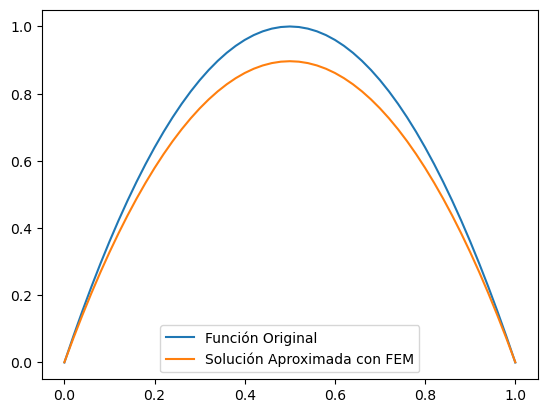

In [41]:
####################################################
# Solve Primal

y0_T1 = forward_prob(yn_T1,source)

####################################################
# Plot Solutions and Functions

'''
Revisa qu'e lo que est'as graficando aqu'i con yn_T1
y qu'e es lo que querr'ias estar graficando
'''

fn.plot(yn_T1,label='Función Original')
#plt.legend()
#plt.show()  
fn.plot(y0_T1,label='Solución Aproximada con FEM')
plt.legend()
plt.show()    